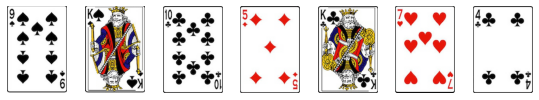

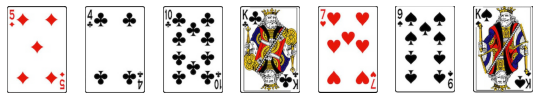

In [8]:
#!pip install pydealer
from hand2hand import Cards
import pydealer
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

deck = Cards()
pydeck = pydealer.Deck()
pydeck.shuffle()
hand = pydeck.deal(7)
deck.show_pyhand(hand)
deck.sort_pyhand(hand)
deck.show_pyhand(hand)


### Classify cards with a CNN

This notebook builds a classifier for individual cards as images, using a CNN. This is done to test the CNN archtecture for building a CNN embedding layer for the transformer architecture.

In [9]:
n = 500
hand_size = 1
X = np.empty((n, 178, 122, 3), dtype=int)
y = np.empty(n, dtype=int)
face_cards = set(['Ace', 'King', 'Queen', 'Jack'])
red_suits = set(['Diamonds', 'Hearts'])

for i in np.arange(n):
    hand = pydeck.deal(hand_size)
    if len(hand) < hand_size:
        # ran out of cards, make a new deck
        pydeck = pydealer.Deck()
        pydeck.shuffle()
        hand = pydeck.deal(hand_size)
    card = hand[0]
    X[i] = deck.image_of_pycard(card)
    y[i] = (card.suit in red_suits)


0

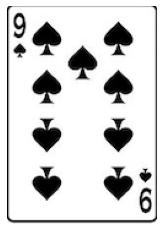

In [10]:
i = np.random.choice(range(n))
plt.imshow(X[i])
plt.axis('off')
y[i]

In [11]:
from seq2seq_transformer import Encoder
from tensorflow.keras import layers, Model, Sequential
from sklearn.model_selection import train_test_split

class CardCNN():
    def __init__(self, ff_dim1=128, ff_dim2=32):
        img_input = layers.Input(shape=(178, 122, 3))
        x = layers.Conv2D(32, (5, 5), activation='relu')(img_input)
        x = layers.MaxPooling2D((4,4))(x)
        x = layers.Conv2D(32, (5, 5), activation='relu')(x)
        x = layers.MaxPooling2D((4,4))(x)
        x = layers.Flatten()(x)
        x = layers.Dense(ff_dim1, activation='relu')(x)
        x = layers.Dense(ff_dim2, activation='relu')(x)
        outputs = layers.Dense(2, activation='softmax')(x)
        self.model = Model(inputs=img_input, outputs=outputs)
        self.model.summary()
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.model_initial_weights = self.model.get_weights()

    def train(self, X_train, y_train, epochs=2):
        self.model.set_weights(self.model_initial_weights)
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=1)

    def predict(self, X_test):
        out = self.model.predict(X_test)
        return out



In [12]:
cc = CardCNN(ff_dim1=64, ff_dim2=32)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 178, 122, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 174, 118, 32)      2432      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 43, 29, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 39, 25, 32)        25632     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 9, 6, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1728)              0   

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
cc.train(X_train, y_train, epochs=3)

Epoch 1/3
12/12 [==============================] - 3s 212ms/step - loss: 15.4178 - accuracy: 0.5973
Epoch 2/3
12/12 [==============================] - 3s 213ms/step - loss: 0.5234 - accuracy: 0.8933
Epoch 3/3
12/12 [==============================] - 3s 225ms/step - loss: 0.0419 - accuracy: 0.9760


In [14]:
out = cc.predict(X_test)
yhat_test = np.argmax(out, axis=1)
print('accuracy: %.2f%%' % (100*np.sum(yhat_test == y_test)/len(y_test)))

4/4 [==============================] - 0s 71ms/step
accuracy: 100.00%
